In [1]:
import fastai
from fastai.vision import *
# from fastai.metrics import fbeta, Precision, Recall, accuracy_thresh
from sklearn.metrics import roc_auc_score, recall_score, classification_report, confusion_matrix

In [2]:
fastai.__version__

'1.0.47'

In [3]:
import pandas as pd
import numpy as np

import os
import shutil
from pathlib import Path
import tarfile
import re

import matplotlib.pyplot as plt
from matplotlib.image import imread

from PIL import Image

In [4]:
path_data = Path('../data')

df_labs = pd.read_csv(path_data/'ComParE2018_AtypicalAffect.txt', sep='\t')

df_labs['file_name'] = df_labs['file_name'].str.replace('wav', 'png')

df_labs['subset'] = df_labs['file_name'].str.extract(r'([a-z]+)')
df_labs['subset'][df_labs['subset'] == 'devel'] = 'Valid'
df_labs['subset'][df_labs['subset'] == 'train'] = 'Train' 
df_labs['subset'][df_labs['subset'] == 'test'] = 'Test' 
# df_labs['subset'].value_counts()
df_labs.head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  import sys


,file_name,emotion,subset
0,train_0001.png,neutral,Train
1,train_0002.png,neutral,Train
2,train_0003.png,neutral,Train
3,train_0004.png,neutral,Train
4,train_0005.png,neutral,Train


In [5]:
print(df_labs.query('subset=="Valid"')['emotion'].value_counts())
print(df_labs['subset'].value_counts())

df_train = df_labs.query('subset=="Train"')
df_valid = df_labs.query('subset=="Valid"')
print(df_train['emotion'].value_counts())

neutral    2024
happy       709
sad         234
angry        33
Name: emotion, dtype: int64
Train    3342
Valid    3000
Test      999
Name: subset, dtype: int64
neutral    2287
happy       743
sad         187
angry       125
Name: emotion, dtype: int64


In [6]:
def resampled_df(n_angry=1000, 
                 n_sad=1000,
                 n_happy=1000,
                 n_neutral=1000,
                seed=1):
    np.random.seed(seed)

    return pd.concat(
            [
                df_train.query('emotion=="angry"').sample(n=n_angry, replace=True),
                df_train.query('emotion=="sad"').sample(n=n_sad, replace=True),
                df_train.query('emotion=="happy"').sample(n=n_happy, replace=True),
                df_train.query('emotion=="neutral"').sample(n=n_neutral, replace=True),
                df_valid
            ],
            axis=0
        )

df_resampled = resampled_df()

In [7]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=4.0, 
    max_zoom=1.2, 
    max_lighting=0.2, 
    max_warp=0.15, 
    p_affine=0.75, 
    p_lighting=0.75
)

basic_block = (fastai.vision.ImageList
               .from_df(path=path_data/'spectogram', 
                        df=df_resampled, 
                        cols='file_name')
               .split_by_idx(valid_idx=df_resampled.query('subset=="Valid"').index)
               .label_from_df(cols=1)
              )

db_speech = (basic_block
            .transform(tfms, 
                       size=128) 
            .databunch(bs=64))

db_speech.normalize(imagenet_stats)

# db_speech.export()



ImageDataBunch;

Train: LabelList (4000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
angry,angry,angry,angry,angry
Path: ../data/spectogram;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
neutral,neutral,neutral,neutral,neutral
Path: ../data/spectogram;

Test: None

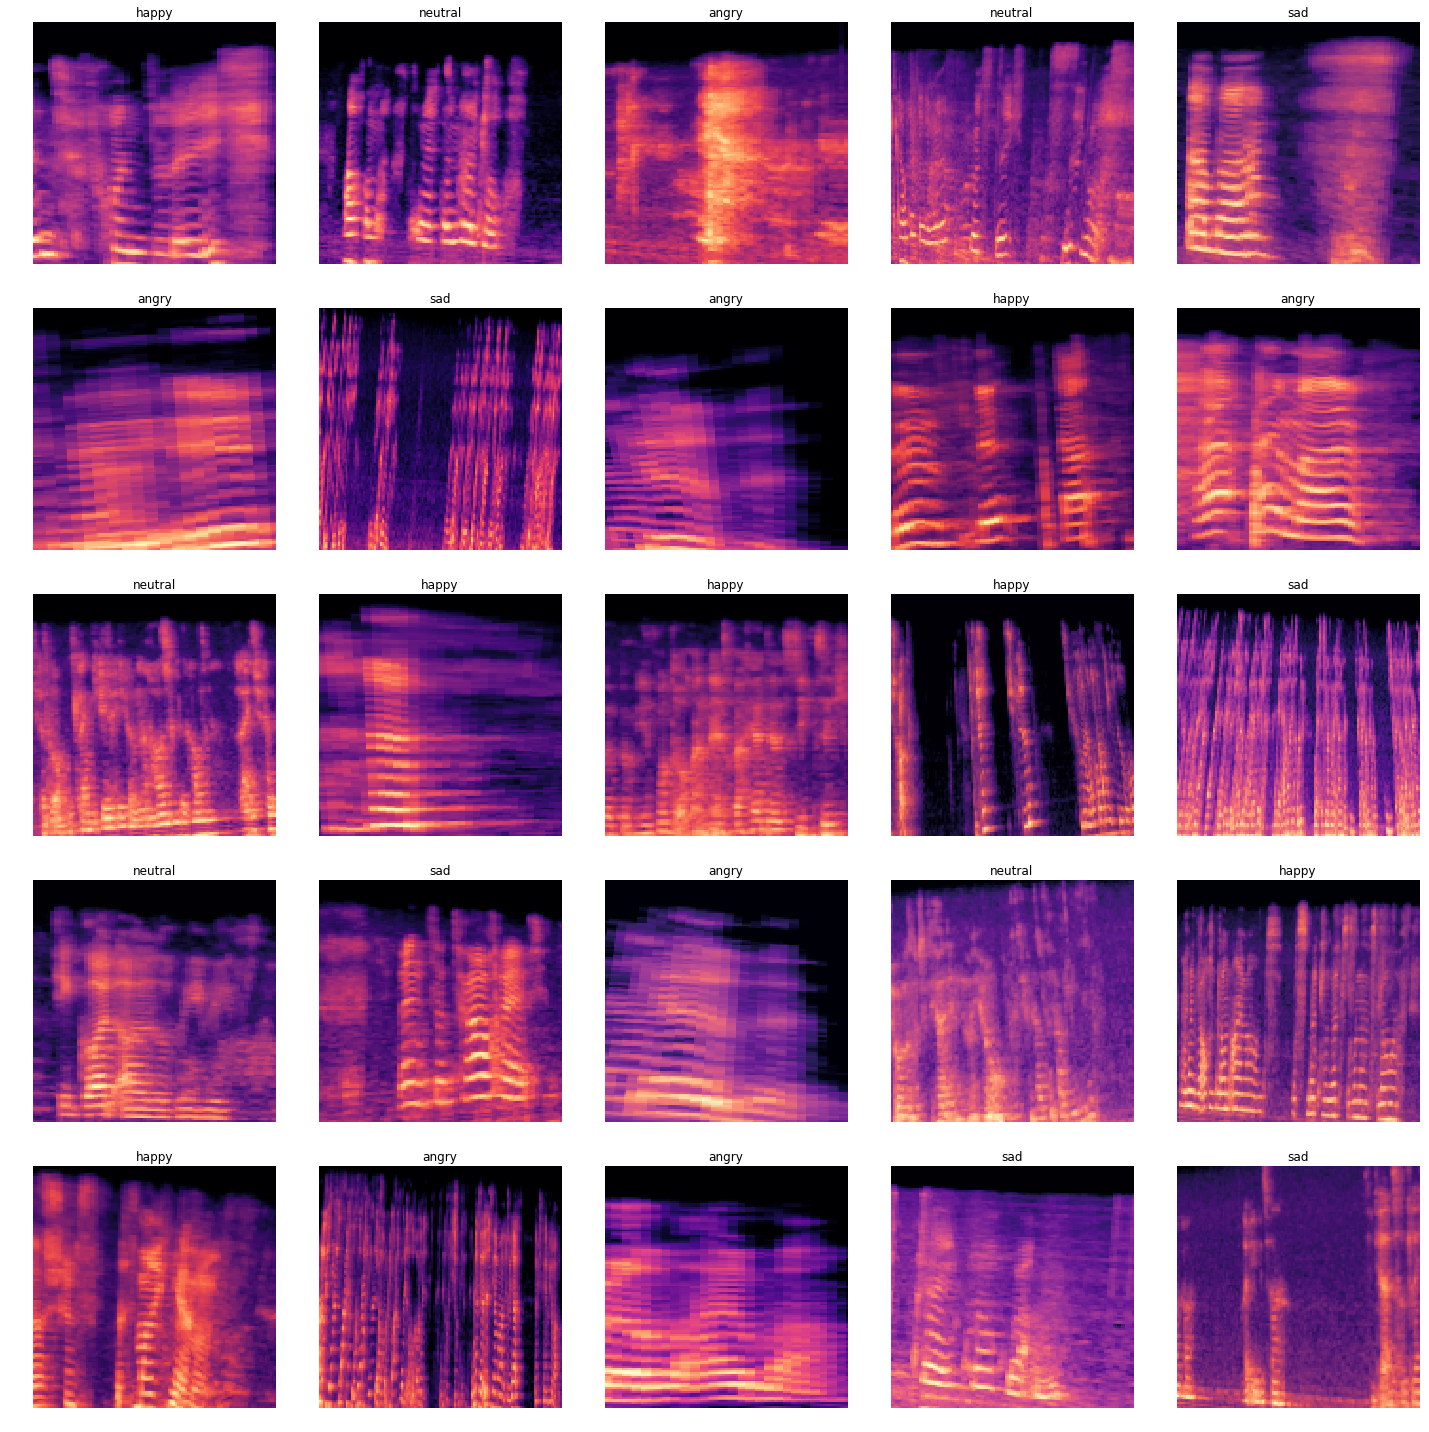

In [8]:
db_speech.show_batch()

In [9]:
def unweighted_average_recall(input_, target):
    input_, target = input_.cpu().numpy(), target.cpu().numpy() 
    input_ = np.argmax(input_, axis=1)
#     print(recall_score(target, input_, average='macro', labels=['angry', 'happy', 'neutral', 'sad']))
    return recall_score(target, input_, average='macro')


class UAR(Callback):
    _order = -20 #Needs to run before the recorder
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs): 
        self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = unweighted_average_recall(output, target)
            return add_metrics(last_metrics, metric)

In [10]:
model = cnn_learner(data=db_speech, 
                   base_arch=models.resnet50, 
                   metrics=[accuracy, UAR()])

In [11]:
model.data.c, model.data.classes

(4, ['angry', 'happy', 'neutral', 'sad'])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


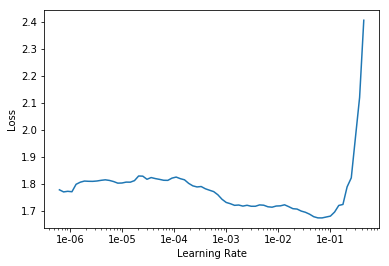

In [12]:
model.lr_find()
model.recorder.plot()

In [13]:
# model.fit_one_cycle(cyc_len=5, max_lr=5e-3)
model.fit_one_cycle(cyc_len=10, max_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,uar,time
0,1.375595,1.588662,0.321000,0.331918,00:09
1,1.192367,1.321089,0.489333,0.356676,00:08
2,1.141225,1.841444,0.337667,0.389580,00:08
3,1.018121,1.027959,0.557000,0.305468,00:08
4,0.937390,1.522572,0.297667,0.325712,00:08
5,0.845443,1.288975,0.461667,0.351555,00:08
6,0.768962,1.230685,0.448333,0.350570,00:08
7,0.647792,1.172757,0.483333,0.379288,00:08
8,0.520309,1.133653,0.541000,0.332709,00:08
9,0.442517,1.113352,0.560333,0.359893,00:08


In [14]:
model.save('stage1-128')

In [15]:
model.load('stage1-128')
model.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


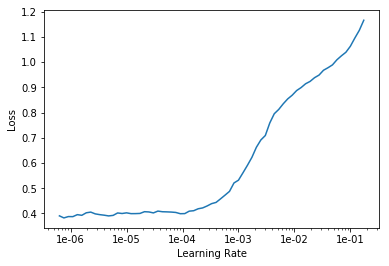

In [16]:
model.lr_find()
model.recorder.plot()

In [19]:
model.fit_one_cycle(cyc_len=8, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,uar,time
0,0.386718,1.129277,0.543667,0.365533,00:09
1,0.381522,1.100863,0.562333,0.353031,00:09
2,0.366669,1.106762,0.561667,0.383193,00:09
3,0.343930,1.136842,0.550667,0.370569,00:09
4,0.332922,1.123143,0.558333,0.366899,00:09
5,0.298495,1.121033,0.564000,0.374979,00:09
6,0.296400,1.129652,0.563667,0.382199,00:09
7,0.290196,1.105743,0.569667,0.371134,00:09


In [19]:
# model.fit_one_cycle(cyc_len=5, max_lr=slice(1e-5, 1e-4))

In [20]:
model.save('stage2-128')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


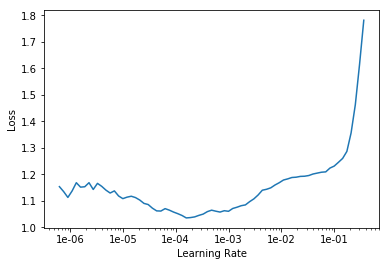

In [21]:
model.load('stage2-128')

model.data = (basic_block
            .transform(tfms, 
                       size=224) 
            .databunch(bs=64))

model.lr_find()
model.recorder.plot()

In [22]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,uar,time
0,0.953377,1.240997,0.518000,0.365806,00:19
1,0.724283,1.269727,0.515333,0.367930,00:19
2,0.555584,1.176081,0.511667,0.342797,00:18
3,0.473036,1.068380,0.585000,0.343496,00:19
4,0.415362,1.099845,0.559667,0.365731,00:18
5,0.366911,1.072306,0.563333,0.366674,00:18


In [23]:
model.save('stage3-128')

In [24]:
model.load('stage3-128')

model.data = (basic_block
            .transform(tfms, 
                       size=224) 
            .databunch(bs=64))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


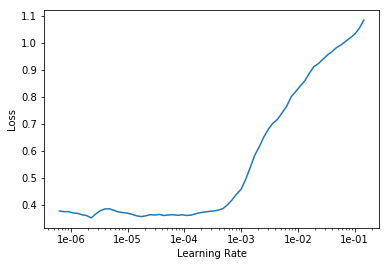

In [25]:
model.lr_find()
model.recorder.plot()

In [26]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,uar,time
0,0.353500,1.139379,0.541000,0.374372,00:19
1,0.365664,1.078727,0.595667,0.379873,00:19
2,0.333671,1.217456,0.524333,0.394146,00:19
3,0.308634,1.024220,0.608333,0.391257,00:19
4,0.258475,1.026478,0.597667,0.369287,00:18
5,0.235295,1.004418,0.605333,0.363469,00:19


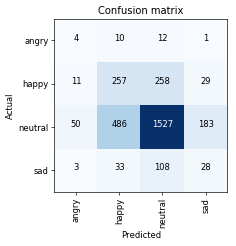

In [27]:
interp = ClassificationInterpretation.from_learner(model)

interp.plot_confusion_matrix(figsize=(4, 4), dpi=60)

In [28]:
val_preds = model.get_preds(ds_type=DatasetType.Valid)[0].cpu().numpy()
val_preds = np.array(model.data.classes)[np.argmax(val_preds, axis=1)]
val_true = model.data.valid_ds.y.items
val_true = np.array(model.data.classes)[val_true]

In [29]:
recall_score(val_true, val_preds, average='macro')

0.36346931070315275

In [30]:
model.data.add_test(ImageList
                    .from_df(df_labs.query('subset=="Test"'),
                             path=path_data/'spectogram'))

In [31]:
test_preds = model.get_preds(ds_type=DatasetType.Test)[0].cpu().numpy()
test_preds = np.array(model.data.classes)[np.argmax(test_preds, axis=1)]
test_true = df_labs.query('subset=="Test"')['emotion'].values
# test_true = np.array(model.data.classes)[val_true]

In [32]:
recall_score(test_true, test_preds, average='macro')

0.3514611526375683

In [33]:
print(classification_report(val_true, val_preds))
print(confusion_matrix(test_true, test_preds))

             precision    recall  f1-score   support

      angry       0.06      0.15      0.08        27
      happy       0.33      0.46      0.38       555
    neutral       0.80      0.68      0.74      2246
        sad       0.12      0.16      0.14       172

avg / total       0.67      0.61      0.63      3000

[[  0   9   4   1]
 [  8  97 101  11]
 [  7 140 510  34]
 [  1  16  43  17]]
